In [ ]:
# Notes: This code is inspired by Andrej Karpathy's video series on youtube. https://github.com/karpathy/micrograd/blob/master/micrograd/engine.py
# After watching the video once I am attempting to recreate the code from memory. Hopefully I can turn it into something usable as a fun project.
# - Aryan M

In [39]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import plot

In [34]:
# Value class
class Value:
    
    """Value class that stores a single scalar value and its gradient, also added functions to be able to add/multiply objects."""
    
    def __init__(self, value, _children=(), _op = ""):
        self.label = ""
        self.value = value
        self.grad = 0.0
        self._prev = set(_children)
        self._operation = _op
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # checks if it is a value at first and if not, it creates a value
        out = Value(self.value + other.value, (self, other), "+")   # adds just the values of the Value data tyupes
        self._prev.add(out)
        other._prev.add(out)
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # checks if it is a value at first and if not, it creates a value
        out = Value(self.value * other.value, (self, other), "*")
        
        # add previous to the children
        self._prev.add(out)
        other._prev.add(out)
        return out
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def __rmul__(self, other):
        return self.__mul__(other)

    def __repr__(self):
        return f'Value({self.label + ": " if self.label != "" else self.label}Data: {self.value}, Grad: {self.grad})' # Didnt even know you could add functions like that but glad I tried it

In [15]:
def printPurple(string): 
    """Literally just prints text in purple.. why not?"""
    print(f'\033[35m{string}\033[0m')

In [16]:
# Testing the prototype for the Value class

x = Value(2.0)  ; x.label = 'x'
y = Value(3.0)  ; y.label = 'y'
j = Value(10.0) ; j.label = 'j'

z = y * j   ; z.label = 'z'
f = x + z   ; f.label = 'f'

printPurple(f'\n{z}')
print("z Previous: " , z._prev, "\n")
printPurple(f)
print("f Previous: ", f._prev)                  # Added _prev to track children

printPurple("\nTesting radd and rmul:")
print(2.0 + x, "\t",x + 2.0)                    # Added radd
print(6.0 * x, "\t", x * 6.0)                   # Added rmul

printPurple("\nDockstring for Value Class: ")
print(Value.__doc__)                            # added docstring


Value(z: Data: 30.0, Grad: 0.0)
z Previous:  {Value(y: Data: 3.0, Grad: 0.0), Value(j: Data: 10.0, Grad: 0.0), Value(f: Data: 32.0, Grad: 0.0)} 

Value(f: Data: 32.0, Grad: 0.0)
f Previous:  {Value(z: Data: 30.0, Grad: 0.0), Value(x: Data: 2.0, Grad: 0.0)}

Testing radd and rmul:
Value(Data: 4.0, Grad: 0.0) 	 Value(Data: 4.0, Grad: 0.0)
Value(Data: 12.0, Grad: 0.0) 	 Value(Data: 12.0, Grad: 0.0)

Dockstring for Value Class: 
Value class that stores a single scalar value and its gradient, also added functions to be able to add/multiply objects.


TypeError: 'NoneType' object is not iterable

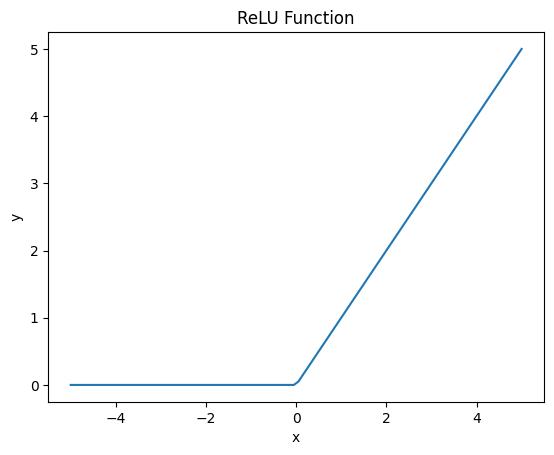

In [40]:
# making a graphical representation of a Relu function
def reluPlot():
    def relu(x):
        return np.maximum(0, x)

    # Generate x values
    x = np.linspace(-5, 5, 100)

    # Calculate corresponding y values using the ReLU function
    y = relu(x)
    
    plot("ReLU Function", "x", "y", x, y)
    
reluPlot()